In [88]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [89]:
import matplotlib.pyplot as plt
import numpy as np

from utf8_generator import get_8bit_unicode
import transmitter
import receiver
import client

# Define parameters

In [90]:
plt.rcParams["figure.figsize"] = (14,4)
ENCODING = 'utf-8'
ENDIANNESS = 'little'

n_max = 60000

nbChars = 10
N0 = 30
T = n_max/N0        # Bien si T est multiple de 3 non?

assert N0 % 3 == 0

# Generate text to be transmit

In [91]:
text = get_8bit_unicode(nbChars)
print(' '.join([hex(ord(s)) for s in text]))
print(bytes(text, ENCODING))

0x63 0x15 0x24 0x4f 0x5a 0x47 0x3d 0x3f 0x62 0x7
b'c\x15$OZG=?b\x07'


In [92]:
# Write it to file
clear_message_filename = 'message.txt'
with open(clear_message_filename, 'wb') as f:
    f.write(bytes(text, ENCODING))
print(f"Text written to: {clear_message_filename}")

Text written to: message.txt


# Prepare transmission

## Encode to bits

In [110]:
bits = transmitter.encoder(text)
bits

array([1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 1])

## Map to {-1,1}

In [111]:
seq = transmitter.mapper(bits)
print(f"{len(seq)} symbols")
seq

70 symbols
First ten: [ 1  1 -1 -1 -1  1  1 -1 -1  1]


array([ 1,  1, -1, -1, -1,  1,  1, -1, -1,  1, -1,  1, -1,  1, -1,  1, -1,
       -1,  1, -1, -1,  1, -1, -1,  1,  1,  1,  1,  1, -1,  1,  1, -1,  1,
       -1,  1, -1, -1, -1,  1,  1,  1, -1,  1,  1,  1,  1, -1,  1, -1,  1,
        1,  1,  1,  1,  1,  1,  1, -1, -1, -1,  1, -1, -1, -1, -1, -1,  1,
        1,  1])

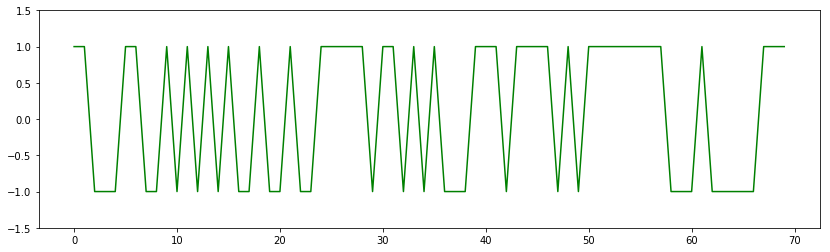

In [108]:
plt.plot(seq, 'green')
plt.ylim([-1.5,1.5])
plt.show()

## Build pulse-train

In [96]:
def psi(t, T):
    return np.sinc(t/T)/np.sqrt(T)

In [184]:
t = np.arange(n_max)

signal = transmitter.w(np.arange(len(t)), seq, psi, T)
print(f"Min : {min(signal):.4f}\tMax :  {max(signal):.4f}\tNbElem: {len(signal)}")
signal

Min : -0.0463	Max :  0.0379	NbElem: 60000


array([0.02236068, 0.02238471, 0.02240874, ..., 0.02224279, 0.0222821 ,
       0.0223214 ])

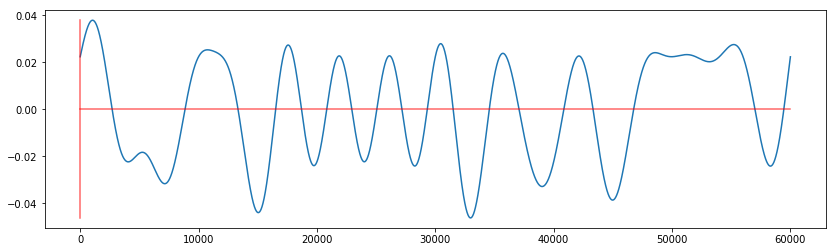

In [212]:
plt.plot(t, signal)
plt.plot([0,0], [min(signal), max(signal)], 'red', alpha=0.6)
plt.plot([min(t), max(t)], [0,0], 'red', alpha=0.6)
plt.show()

In [154]:
# Write it to file
np.savetxt('input.txt', signal)

# Pass signal through the channel

In [155]:
%run client.py

<Figure size 1008x288 with 0 Axes>

# Process result

## Import output of channel

In [156]:
out = np.loadtxt('output.txt')

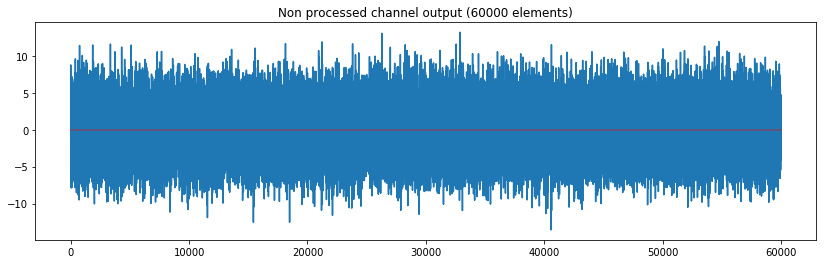

In [208]:
plt.title(f'Non processed channel output ({len(out)} elements)')
plt.plot(t, out)
plt.plot([min(t), max(t)], [0,0], 'red', alpha=0.4)
plt.show()

## Removing wrong index

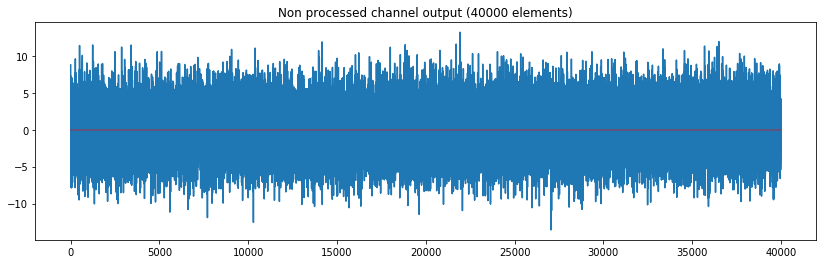

In [205]:
processed, H_hat = receiver.remove_index(out)
t_processed = np.arange(len(processed))

plt.title(f'Non processed channel output ({len(processed)} elements)')
plt.plot(t_processed, processed)
plt.plot([min(t_processed), max(t_processed)], [0,0], 'red', alpha=0.4)
plt.show()

## Performing filtering

In [198]:
# Amplify the signal
g = 100
amplified = processed

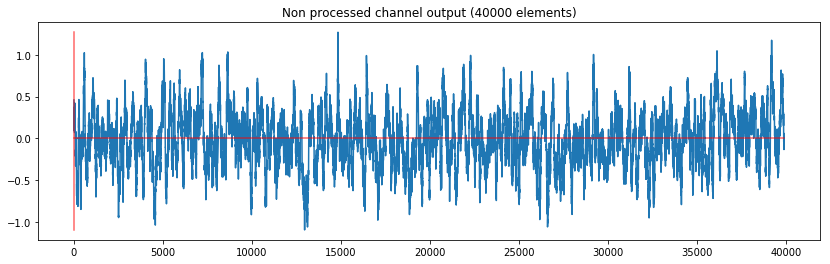

In [207]:
ma_window = 100
ma = receiver.remove_noise(amplified, ma_window)
t_ma = np.arange(len(ma))

plt.title(f'Non processed channel output ({len(processed)} elements)')
plt.plot(t_ma, ma)

plt.plot([0, t_ma[-1]], [0,0], 'red', alpha=0.6)
plt.plot([0,0], [min(ma), max(ma)], 'red', alpha=0.6)
plt.show()

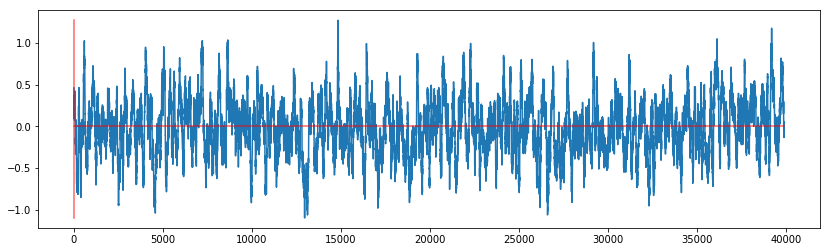

In [206]:
t_recovered = np.arange(len(ma))
y_recovered = np.interp(t_recovered, t_recovered, ma)
plt.plot(t_recovered, y_recovered)
plt.plot([0, t_recovered[-1]], [0,0], 'red', alpha=0.6)
plt.plot([0,0], [min(y_recovered), max(y_recovered)], 'red', alpha=0.6)
plt.show()